In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

In [3]:
df_buss_table = pd.read_csv("C:\\Users\\pc\\Downloads\\Businesses_table.csv")

In [4]:
data = pd.read_csv("C:\\Users\\pc\\Downloads\\transaction_subset.csv", parse_dates= True)

In [5]:
data.dtypes

transaction_uuid      object
business_uuid         object
created               object
transaction_type      object
amount_usd           float64
transaction_state     object
processing_time      float64
phone_type            object
reader_type           object
connection_type       object
dtype: object

In [6]:
data.shape

(15391, 10)

#### check for missing values

In [7]:
data.isnull().sum(axis=0)

transaction_uuid        0
business_uuid           1
created                 1
transaction_type        1
amount_usd              1
transaction_state       1
processing_time      1642
phone_type           4540
reader_type          5865
connection_type      6018
dtype: int64

In [8]:
data[data.isnull().any(axis=1)]

,transaction_uuid,business_uuid,created,transaction_type,amount_usd,transaction_state,processing_time,phone_type,reader_type,connection_type
0,1424437465609-285a18be-f2fa-4d4c-a2ef-3bef9f3e...,1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...,2015-02-20 13:04:25.607+00,credit_card,60,approved,19,NaN,NaN,NaN
6,1436089984929-37f9362f-a4b7-4092-9f76-d45e447a...,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,2015-07-05 09:53:04.927+00,credit_card,145,approved,16,NaN,NaN,NaN
7,1438060492782-ea30db6b-be65-4d4c-a7d9-c6efe474...,1434354856779-1294da8e-95cd-4594-a337-eb1b461b...,2015-07-28 05:14:52.78+00,credit_card,39,approved,15,NaN,NaN,NaN
8,1432304404374-7d6f52c6-b6e1-44e2-bf30-79b24115...,1424869704616-f6183d7b-1482-46ca-87e5-461aeec2...,2015-05-22 14:20:04.372+00,credit_card,10,approved,16,NaN,NaN,NaN
10,1427711746123-1133cea0-5cee-4124-80c9-e9d41c9d...,1414229837135-05cd5b05-3234-46df-9eb3-37f985b5...,2015-03-30 10:35:46.123+00,refund,-110,approved,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
15385,1432977685700-91aab571-f60f-4d29-9ca0-14fef28c...,1423729367094-337ac28c-dae5-4960-afab-19133561...,2015-05-30 09:21:25.698+00,credit_card,210,approved,12,NaN,NaN,NaN
15386,1434115552770-617cb55e-c974-4e67-90cc-3049d881...,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,2015-06-12 13:25:52.768+00,credit_card,170,approved,16,NaN,NaN,NaN
15387,1435408952457-a920b6d0-e627-410e-9ead-0a5cb32b...,1429030235172-cd21ab3c-c47c-4f9a-b1fa-683c8ec5...,2015-06-27 12:42:32.455+00,credit_card,65,approved,14,NaN,NaN,NaN
15389,1447677754844-1e2560d5-24ec-4cae-8a43-d8a2a577...,1444976393870-0a898070-6802-4e0d-9dbd-16b2e03e...,2015-11-16 12:42:32.763+00,cash,75,approved,NaN,ios,NaN,NaN


##### data wrangling

#### create a new dataset df1 so as to retain the original dataframe, then delete the rows where the customers cannot be identified
 

In [9]:
data1 = data.copy()

In [10]:
data1 = data1[pd.notnull(data1["business_uuid"])]

In [11]:
data1.shape

(15390, 10)

In [12]:
data1.head()

,transaction_uuid,business_uuid,created,transaction_type,amount_usd,transaction_state,processing_time,phone_type,reader_type,connection_type
0,1424437465609-285a18be-f2fa-4d4c-a2ef-3bef9f3e...,1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...,2015-02-20 13:04:25.607+00,credit_card,60,approved,19,NaN,NaN,NaN
1,1444994656054-91a37566-c9ce-435a-ae8f-5f9aeb27...,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,2015-10-16 11:24:16.052+00,credit_card,220,approved,16,ios,E105,WiFi
2,1451311977458-d794c535-d696-4830-b4b6-93c52ca5...,1442575726431-a066cad9-8f66-45da-abd8-165ce0a7...,2015-12-28 14:12:57.455+00,credit_card,90,approved,14,ios,E105,WiFi
3,1444763353752-bac376b0-80d9-46f5-9e21-9def71ee...,1436133508444-8d874705-6448-4d8d-88e0-5b0f8f4c...,2015-10-13 19:09:13.75+00,credit_card,135,approved,15,ios,M010,WiFi
4,1449883535047-1a9e1d5e-6151-4593-86db-bf504ab7...,1436123092750-68fb87cc-d43b-4468-9137-2841db30...,2015-12-12 01:25:35.047+00,credit_card,162,approved,15,ios,M010,WiFi


##### reviewing the numerical variables. from results We observe negative amount_usd. These must have been product returns or cancellations. We need to remove their records.

In [13]:
data1[data1["amount_usd"]<=0]

,transaction_uuid,business_uuid,created,transaction_type,amount_usd,transaction_state,processing_time,phone_type,reader_type,connection_type
10,1427711746123-1133cea0-5cee-4124-80c9-e9d41c9d...,1414229837135-05cd5b05-3234-46df-9eb3-37f985b5...,2015-03-30 10:35:46.123+00,refund,-110,approved,NaN,NaN,NaN,NaN
170,1441119319455-ff54e03b-4ba2-4637-af01-addab1cb...,1413213171217-be88b1f4-ae0d-46c9-9210-ab72e2d5...,2015-09-01 14:55:19.455+00,refund,-2,approved,NaN,NaN,NaN,NaN
375,1444827045662-081aca09-fecc-47d2-978d-28abb566...,1413213171217-be88b1f4-ae0d-46c9-9210-ab72e2d5...,2015-10-14 12:50:45.662+00,refund,-1,approved,NaN,NaN,NaN,NaN
392,1440667213859-20fe5990-8732-44c2-a977-3a6c4bec...,1436882887795-63ca1223-bbf2-455e-9693-1a2ae62a...,2015-08-27 09:20:13.859+00,refund,-2,approved,NaN,NaN,NaN,NaN
490,1421169160288-da9a4418-df59-419f-b015-33477f49...,1413213171217-be88b1f4-ae0d-46c9-9210-ab72e2d5...,2015-01-13 17:12:40.288+00,refund,-140,approved,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14751,1441025517936-27959de8-0b46-496e-8afa-fb7f90cd...,1439395992943-30dad8bf-6d97-47f1-a59b-f32be589...,2015-08-31 12:51:57.936+00,refund,"-1,400",approved,NaN,NaN,M010,NaN
14775,1440005671206-94d70acc-45ba-4d46-af39-0e62c841...,1413213171217-be88b1f4-ae0d-46c9-9210-ab72e2d5...,2015-08-19 17:34:31.206+00,refund,-20,approved,NaN,NaN,NaN,NaN
14981,1432798700199-34278ae2-b05b-4b39-aa29-e167a475...,1413213171217-be88b1f4-ae0d-46c9-9210-ab72e2d5...,2015-05-28 07:38:20.199+00,refund,-1,approved,NaN,NaN,NaN,NaN
15116,1443686368975-75b3723d-a411-4c7d-b61e-0072f286...,1413213171217-be88b1f4-ae0d-46c9-9210-ab72e2d5...,2015-10-01 07:59:28.975+00,refund,-1,approved,NaN,NaN,NaN,NaN


In [14]:
data1.describe()

,amount_usd,processing_time
count,"15,390","13,749"
mean,290,24
std,"1,505",365
min,"-4,633",-10
25%,57,12
50%,128,15
75%,275,20
max,"100,455","41,772"


### thus the dataset will be restricted to positive amounts in usd 

In [15]:
data1 = data1[data1["amount_usd"]>0]

In [16]:
data1.head()

,transaction_uuid,business_uuid,created,transaction_type,amount_usd,transaction_state,processing_time,phone_type,reader_type,connection_type
0,1424437465609-285a18be-f2fa-4d4c-a2ef-3bef9f3e...,1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...,2015-02-20 13:04:25.607+00,credit_card,60,approved,19,NaN,NaN,NaN
1,1444994656054-91a37566-c9ce-435a-ae8f-5f9aeb27...,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,2015-10-16 11:24:16.052+00,credit_card,220,approved,16,ios,E105,WiFi
2,1451311977458-d794c535-d696-4830-b4b6-93c52ca5...,1442575726431-a066cad9-8f66-45da-abd8-165ce0a7...,2015-12-28 14:12:57.455+00,credit_card,90,approved,14,ios,E105,WiFi
3,1444763353752-bac376b0-80d9-46f5-9e21-9def71ee...,1436133508444-8d874705-6448-4d8d-88e0-5b0f8f4c...,2015-10-13 19:09:13.75+00,credit_card,135,approved,15,ios,M010,WiFi
4,1449883535047-1a9e1d5e-6151-4593-86db-bf504ab7...,1436123092750-68fb87cc-d43b-4468-9137-2841db30...,2015-12-12 01:25:35.047+00,credit_card,162,approved,15,ios,M010,WiFi


### change the date created variable from object to datetime, here we use the dt.date method to remove the time componen from the created time column 

In [17]:
data1["created"] = pd.to_datetime(data1["created"]).dt.date

In [18]:
data1["created"] = data1["created"].astype("datetime64[ns]")

##### review the categorical variables AND find that The dataset comprises 491 unique business IDs and 361 dates within the time horizon.

In [19]:
data1.describe(include="object").T

,count,unique,top,freq
transaction_uuid,15237,15236,1429009470977-7f1a01b8-2005-40d3-9e02-ba60ce1c...,2
business_uuid,15237,491,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,907
transaction_type,15237,2,credit_card,14602
transaction_state,15237,5,approved,12121
phone_type,10845,4,ios,9223
reader_type,9523,8,M010,6543
connection_type,9371,11,WiFi,7823


In [20]:
data1["created"].describe()

count                   15237
unique                    361
top       2015-12-18 00:00:00
freq                      177
first     2015-01-02 00:00:00
last      2015-12-30 00:00:00
Name: created, dtype: object

#### pick the neccesary columns that i need for the analysi

In [21]:
neccesary_col = ["created","business_uuid","amount_usd"]
data2 = data1[neccesary_col]
data2.head()

,created,business_uuid,amount_usd
0,2015-02-20,1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...,60
1,2015-10-16,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,220
2,2015-12-28,1442575726431-a066cad9-8f66-45da-abd8-165ce0a7...,90
3,2015-10-13,1436133508444-8d874705-6448-4d8d-88e0-5b0f8f4c...,135
4,2015-12-12,1436123092750-68fb87cc-d43b-4468-9137-2841db30...,162


In [22]:
data2.shape

(15237, 3)

### to check the last transaction date from the date time column

In [23]:
lastorder_date = data2["created"].max()
print(lastorder_date)

2015-12-30 00:00:00


### then we use the bult in utility function (summary_data_from_transaction_data) from lifetimes package to transform the transactional data (one row per purchase) into summary data (frequency, recency and monetary)


In [24]:
lt_data2 = summary_data_from_transaction_data(data2, "business_uuid", "created", monetary_value_col="amount_usd", observation_period_end = "2015-12-30 00:00:00" )

###### the T variable below indicates the period between the date of transaction and the observed  period end

In [25]:
lt_data2.reset_index().head()

,business_uuid,frequency,recency,T,monetary_value
0,1406276528708-f8212391-f625-47cd-a108-dbf13c4a...,2,202,251,746
1,1407937721690-22878388-e481-46cb-8384-5dea1658...,28,336,348,316
2,1408597458035-ae9b4dc2-37a2-43b3-8410-834feb19...,135,357,361,152
3,1408653254676-abd0c2bb-f33c-42f0-a4c0-aa09011e...,17,249,339,418
4,1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...,38,348,356,289


### we create a histogram to check how many custoemers purchsed more than once. from the histogram we see that there is a spike at the first date of transaction meaning most of the customers only transacted once

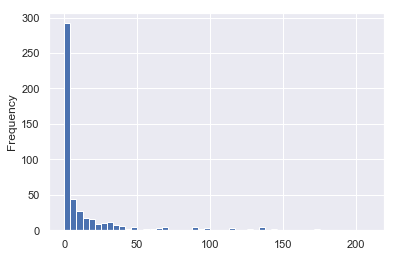

In [26]:
lt_data2["frequency"].plot(kind="hist", bins = 50)

#### from the results below it can be seen that the analysis is perfomed on 491 customers and the average number of repeat transactions is 16 transactions which means customers on an average make 14 transactions

In [27]:
print(lt_data2.frequency.describe())

count   491
mean     16
std      32
min       0
25%       0
50%       2
75%      14
max     209
Name: frequency, dtype: float64


#### to obtain the one time transaction customers

In [28]:
onetime_buyers = round(sum(lt_data2["frequency"] == 0)/float(len(lt_data2))*(100),2)
print("the percentage of customers who transacted only once:",onetime_buyers, "%")

the percentage of customers who transacted only once: 27.49 %


### fitting the BG/NBD model to analyse the frequency/ recency

In [29]:
bgf_model = BetaGeoFitter(penalizer_coef=0.0)
bgf_model.fit(lt_data2["frequency"], lt_data2["recency"], lt_data2["T"])
print(bgf_model)

<lifetimes.BetaGeoFitter: fitted with 491 subjects, a: 0.09, alpha: 2.68, b: 0.97, r: 0.43>


In [30]:
bgf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0,0,0,0
alpha,3,0,2,3
a,0,0,0,0
b,1,0,0,2


#### plotting our frequency/recency matrix which calculates the expected number of transactions a particular customer can make in the next time period based on his recency value that is age from last value and frequency value which is the number of transactions he has made. from the heatmap below the best customer is the one who has transacted 200 times and has a recency of 350. the no so good customer who transacts only once are represented on the top right corner

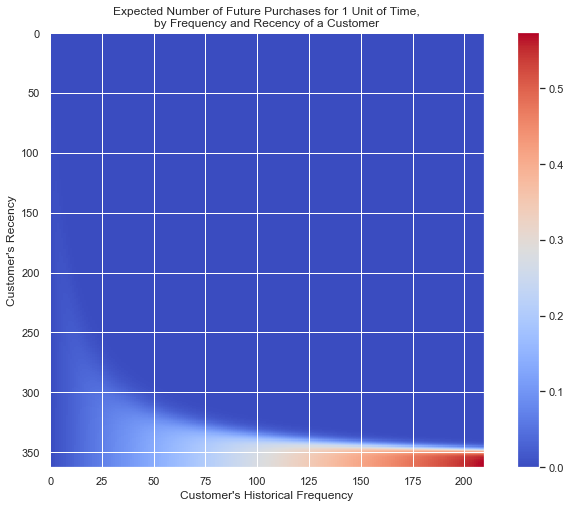

In [31]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf_model)

#### here we are building prob matrix for the customers who are alive. an alive customer from the heatmap is the one who has had his last puchace when he was 350 days old and has transacted 200 times

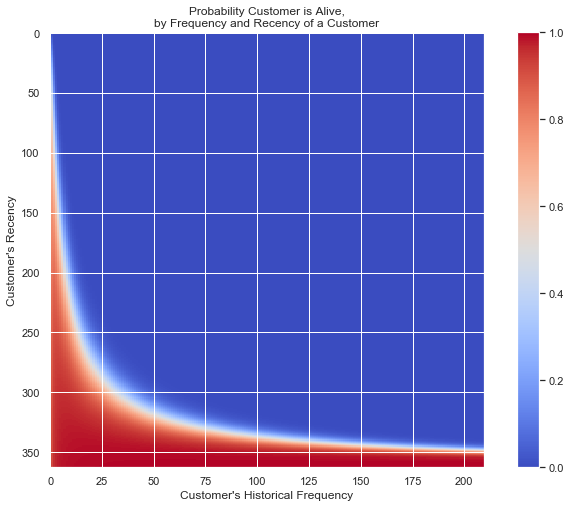

In [32]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf_model)

#### Next, we Predict future transaction in next 10 days i.e.top 10 customers that the model expects them to make transactions in the next 10 days, based on historical data for example the first customer is expected to make 9 transactions in the next 10 days

In [33]:
t = 10 #set the number of days to 10
lt_data2["predicted_transactions"] = round(bgf_model.conditional_expected_number_of_purchases_up_to_time(t,lt_data2["frequency"],lt_data2["recency"],lt_data2["T"]))
lt_data2.sort_values(by="predicted_transactions", ascending=False).head(10).reset_index()

,business_uuid,frequency,recency,T,monetary_value,predicted_transactions
0,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,209,223,223,"1,960",9
1,1440051882363-1378cba4-3b54-4f79-bf18-7045610a...,91,103,103,702,9
2,1444640278681-657b87fa-93b2-4314-8da0-79691a84...,63,67,67,364,9
3,1434354856779-1294da8e-95cd-4594-a337-eb1b461b...,175,195,195,297,9
4,1443443143895-d23c7c27-416b-41eb-9d6d-2f6b409a...,71,86,87,457,8
5,1434729694021-714fe9df-a366-4d84-b713-9564bd74...,140,188,188,465,7
6,1433319623496-f6231f02-a6f4-4360-a556-eb1ca83b...,136,200,202,226,7
7,1446472415656-44c35dce-e20d-464a-bc11-7243fddf...,34,48,48,598,7
8,1429188663924-25474853-52e5-40c2-aab3-9fd98d41...,172,236,243,233,7
9,1443173830686-182c32d4-9a13-44ec-9610-8bccec45...,64,95,95,"2,169",7


### to assess the model fit for the predicted values thus we can see that the model is performing well since actual and model based values are really close

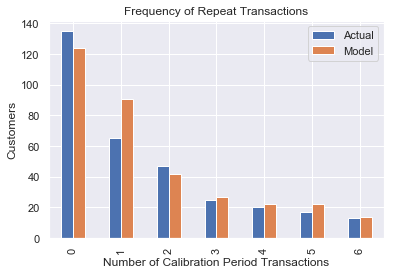

In [34]:
plot_period_transactions(bgf_model)

### gamma gamma model assumes tht their is no correlation between monetary value and transaction frequency thus Check if there is correlation between monetary value and frequency in order to use gamma gamma model for CLV calculation\

In [35]:
lt_data2[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1,-0
frequency,-0,1


In [36]:
#Shortlist customers who had at least one repeat purchase with the company. 
shortlisted_customers = lt_data2[lt_data2['frequency']>0]
print(shortlisted_customers.head().reset_index())
print("-----------------------------------------")
print("The Number of Returning Customers are: ",len(shortlisted_customers))

                                       business_uuid  frequency  recency   T  \
0  1406276528708-f8212391-f625-47cd-a108-dbf13c4a...          2      202 251   
1  1407937721690-22878388-e481-46cb-8384-5dea1658...         28      336 348   
2  1408597458035-ae9b4dc2-37a2-43b3-8410-834feb19...        135      357 361   
3  1408653254676-abd0c2bb-f33c-42f0-a4c0-aa09011e...         17      249 339   
4  1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...         38      348 356   

   monetary_value  predicted_transactions  
0             746                       0  
1             316                       1  
2             152                       4  
3             418                       0  
4             289                       1  
-----------------------------------------
The Number of Returning Customers are:  356


#### #Train gamma-gamma model by taking into account the monetary_value.

In [37]:
gamma_gamma_model = GammaGammaFitter(penalizer_coef = 0)
gamma_gamma_model.fit(shortlisted_customers['frequency'],shortlisted_customers['monetary_value'])
print(gamma_gamma_model)

<lifetimes.GammaGammaFitter: fitted with 356 subjects, p: 0.73, q: 1.18, v: 416.26>


### After applying Gamma-Gamma model, now we can estimate average transaction value for each customer using the conditional_expected_average_profit method here we can see that 

In [38]:
print(gamma_gamma_model.conditional_expected_average_profit(lt_data2['frequency'], lt_data2['monetary_value']).head(10))

business_uuid
1406276528708-f8212391-f625-47cd-a108-dbf13c4a82b9     852
1407937721690-22878388-e481-46cb-8384-5dea165864f7     328
1408597458035-ae9b4dc2-37a2-43b3-8410-834feb1930ab     154
1408653254676-abd0c2bb-f33c-42f0-a4c0-aa09011e13e0     437
1409234980651-de3fff31-3d87-47e4-bb1a-12beafcdba61     298
1409908058188-55c15510-480c-4a6c-a470-b4a1e5006cc0     968
1411120534868-d0e07e18-26b7-4e26-a0f3-45736855c3cd     657
1412941920235-309e274b-c95b-49f1-8a78-307238281817      49
1413213171217-be88b1f4-ae0d-46c9-9210-ab72e2d5c666   1,477
1413229685934-2736f63b-6a6c-40a2-9d7a-2f479cc3a890     163
dtype: float64


### add new column on the summary dataframe

In [39]:
lt_data2['pred_txn_value'] = round(gamma_gamma_model.conditional_expected_average_profit(lt_data2['frequency'], lt_data2['monetary_value']), 2)
lt_data2.reset_index().head()

,business_uuid,frequency,recency,T,monetary_value,predicted_transactions,pred_txn_value
0,1406276528708-f8212391-f625-47cd-a108-dbf13c4a...,2,202,251,746,0,852
1,1407937721690-22878388-e481-46cb-8384-5dea1658...,28,336,348,316,1,328
2,1408597458035-ae9b4dc2-37a2-43b3-8410-834feb19...,135,357,361,152,4,154
3,1408653254676-abd0c2bb-f33c-42f0-a4c0-aa09011e...,17,249,339,418,0,437
4,1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...,38,348,356,289,1,298


###### Calculate Customer Lifetime Value AND FROM the results the first customer has the highest customer lifetime value of 586,140 which means that he is likely to purchace 586,140 worth of items in the next 12 months and the average Customer Lifetime Value is 23,155.15

In [40]:
lt_data2['CLV'] = round(gamma_gamma_model.customer_lifetime_value(
    bgf_model, #the model to use to predict the number of future transactions
    lt_data2['frequency'],
    lt_data2['recency'],
    lt_data2['T'],
    lt_data2['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
), 2)

lt_data2.drop(lt_data2.iloc[:, 0:6], inplace=True, axis=1)

lt_data2.sort_values(by='CLV', ascending=False).head(10).reset_index()

,business_uuid,CLV
0,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,"586,140"
1,1443173830686-182c32d4-9a13-44ec-9610-8bccec45...,"444,711"
2,1445859989485-105adb75-9ed1-4062-8ded-4c468087...,"313,353"
3,1439553491873-e1dab1a6-6395-403f-a5c1-2a31a029...,"268,325"
4,1447176760825-e1228667-1a17-4d8e-84d4-3c49869b...,"246,908"
5,1444631878220-30320826-2647-470a-aff6-623f1295...,"219,302"
6,1447671150054-17afb918-94e7-440f-bf5d-5cffe961...,"218,945"
7,1443507623766-d7a7dd32-ca88-45ac-8533-bca483b5...,"213,323"
8,1440051882363-1378cba4-3b54-4f79-bf18-7045610a...,"190,582"
9,1413213171217-be88b1f4-ae0d-46c9-9210-ab72e2d5...,"172,586"


In [42]:
lt_data2["CLV"].mean()

23155.156639511202

## Question 2

### 1.mean processing time on aweekly basis

In [43]:
data3 = data1.copy()

In [44]:
data3 = data3.set_index(['created'])

In [45]:
data3.head()

,transaction_uuid,business_uuid,transaction_type,amount_usd,transaction_state,processing_time,phone_type,reader_type,connection_type
created,,,,,,,,,
2015-02-20,1424437465609-285a18be-f2fa-4d4c-a2ef-3bef9f3e...,1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...,credit_card,60,approved,19,NaN,NaN,NaN
2015-10-16,1444994656054-91a37566-c9ce-435a-ae8f-5f9aeb27...,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,credit_card,220,approved,16,ios,E105,WiFi
2015-12-28,1451311977458-d794c535-d696-4830-b4b6-93c52ca5...,1442575726431-a066cad9-8f66-45da-abd8-165ce0a7...,credit_card,90,approved,14,ios,E105,WiFi
2015-10-13,1444763353752-bac376b0-80d9-46f5-9e21-9def71ee...,1436133508444-8d874705-6448-4d8d-88e0-5b0f8f4c...,credit_card,135,approved,15,ios,M010,WiFi
2015-12-12,1449883535047-1a9e1d5e-6151-4593-86db-bf504ab7...,1436123092750-68fb87cc-d43b-4468-9137-2841db30...,credit_card,162,approved,15,ios,M010,WiFi


In [46]:
weekly_mean_processing_time = data3.resample(rule = "W").mean()["processing_time"]
weekly_mean_processing_time.dropna()

created
2015-02-01   19
2015-02-08   19
2015-02-15   16
2015-02-22   19
2015-03-01   15
2015-03-08   14
2015-03-15   14
2015-03-22   15
2015-03-29   17
2015-04-05   16
2015-04-12   15
2015-04-19   18
2015-04-26   16
2015-05-03   15
2015-05-10   18
2015-05-17   15
2015-05-24   17
2015-05-31   18
2015-06-07   19
2015-06-14   16
2015-06-21   21
2015-06-28   18
2015-07-05   17
2015-07-12   30
2015-07-19   20
2015-07-26   18
2015-08-02   17
2015-08-09   21
2015-08-16   22
2015-08-23   18
2015-08-30   18
2015-09-06   18
2015-09-13   18
2015-09-20   19
2015-09-27   29
2015-10-04   20
2015-10-11   23
2015-10-18   23
2015-10-25   24
2015-11-01   22
2015-11-08   18
2015-11-15   21
2015-11-22   18
2015-11-29   22
2015-12-06   19
2015-12-13   17
2015-12-20   73
2015-12-27   36
2016-01-03   18
Freq: W-SUN, Name: processing_time, dtype: float64

In [47]:
weekly_mean_processing_time.mean()

20.150723322792814

In [48]:
weekly_mean_processing_time.describe()

count   49
mean    20
std      9
min     14
25%     17
50%     18
75%     21
max     73
Name: processing_time, dtype: float64

### 2.transaction approval rate

In [49]:
data1.head()

,transaction_uuid,business_uuid,created,transaction_type,amount_usd,transaction_state,processing_time,phone_type,reader_type,connection_type
0,1424437465609-285a18be-f2fa-4d4c-a2ef-3bef9f3e...,1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...,2015-02-20,credit_card,60,approved,19,NaN,NaN,NaN
1,1444994656054-91a37566-c9ce-435a-ae8f-5f9aeb27...,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,2015-10-16,credit_card,220,approved,16,ios,E105,WiFi
2,1451311977458-d794c535-d696-4830-b4b6-93c52ca5...,1442575726431-a066cad9-8f66-45da-abd8-165ce0a7...,2015-12-28,credit_card,90,approved,14,ios,E105,WiFi
3,1444763353752-bac376b0-80d9-46f5-9e21-9def71ee...,1436133508444-8d874705-6448-4d8d-88e0-5b0f8f4c...,2015-10-13,credit_card,135,approved,15,ios,M010,WiFi
4,1449883535047-1a9e1d5e-6151-4593-86db-bf504ab7...,1436123092750-68fb87cc-d43b-4468-9137-2841db30...,2015-12-12,credit_card,162,approved,15,ios,M010,WiFi


In [51]:
data1["transaction_state"].describe()

count        15237
unique           5
top       approved
freq         12121
Name: transaction_state, dtype: object

In [64]:
data1["transaction_state"].value_counts()

approved    12121
error        1614
aborted      1167
declined      263
refunded       72
Name: transaction_state, dtype: int64

In [53]:
apprv_rate = round(sum(data1["transaction_state"] == "approved")/len(data1["transaction_state"])*(100),2)
print(f"Thus the rate of transaction approval is {apprv_rate}%")

Thus the rate of transaction approval is 79.55%


### 3.credit card transaction rate

In [54]:
data1.head()

,transaction_uuid,business_uuid,created,transaction_type,amount_usd,transaction_state,processing_time,phone_type,reader_type,connection_type
0,1424437465609-285a18be-f2fa-4d4c-a2ef-3bef9f3e...,1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...,2015-02-20,credit_card,60,approved,19,NaN,NaN,NaN
1,1444994656054-91a37566-c9ce-435a-ae8f-5f9aeb27...,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,2015-10-16,credit_card,220,approved,16,ios,E105,WiFi
2,1451311977458-d794c535-d696-4830-b4b6-93c52ca5...,1442575726431-a066cad9-8f66-45da-abd8-165ce0a7...,2015-12-28,credit_card,90,approved,14,ios,E105,WiFi
3,1444763353752-bac376b0-80d9-46f5-9e21-9def71ee...,1436133508444-8d874705-6448-4d8d-88e0-5b0f8f4c...,2015-10-13,credit_card,135,approved,15,ios,M010,WiFi
4,1449883535047-1a9e1d5e-6151-4593-86db-bf504ab7...,1436123092750-68fb87cc-d43b-4468-9137-2841db30...,2015-12-12,credit_card,162,approved,15,ios,M010,WiFi


In [55]:
data1["transaction_type"].value_counts()

credit_card    14602
cash             635
Name: transaction_type, dtype: int64

In [56]:
data1["transaction_type"].describe()

count           15237
unique              2
top       credit_card
freq            14602
Name: transaction_type, dtype: object

In [57]:
cred_trans_rate = round(sum(data1["transaction_type"] == "credit_card")/len(data1["transaction_type"])*(100),2)
print(f"Thus the credit card transaction rate is {cred_trans_rate}%")

Thus the credit card transaction rate is 95.83%


### 4.Average TransACTIONS per week

In [58]:
data3.head()

,transaction_uuid,business_uuid,transaction_type,amount_usd,transaction_state,processing_time,phone_type,reader_type,connection_type
created,,,,,,,,,
2015-02-20,1424437465609-285a18be-f2fa-4d4c-a2ef-3bef9f3e...,1409234980651-de3fff31-3d87-47e4-bb1a-12beafcd...,credit_card,60,approved,19,NaN,NaN,NaN
2015-10-16,1444994656054-91a37566-c9ce-435a-ae8f-5f9aeb27...,1431433133107-089d14c3-5435-4b33-9973-70e2c0ff...,credit_card,220,approved,16,ios,E105,WiFi
2015-12-28,1451311977458-d794c535-d696-4830-b4b6-93c52ca5...,1442575726431-a066cad9-8f66-45da-abd8-165ce0a7...,credit_card,90,approved,14,ios,E105,WiFi
2015-10-13,1444763353752-bac376b0-80d9-46f5-9e21-9def71ee...,1436133508444-8d874705-6448-4d8d-88e0-5b0f8f4c...,credit_card,135,approved,15,ios,M010,WiFi
2015-12-12,1449883535047-1a9e1d5e-6151-4593-86db-bf504ab7...,1436123092750-68fb87cc-d43b-4468-9137-2841db30...,credit_card,162,approved,15,ios,M010,WiFi


In [59]:
data3.resample(rule = "W").nunique()["amount_usd"].mean()

142.32075471698113